In [1]:
from IPython import get_ipython


def type_of_script():
    """
    Detects and returns the type of python kernel
    :return: string 'jupyter' or 'ipython' or 'terminal'
    """
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str:
            return 'jupyter'
        if 'terminal' in ipy_str:
            return 'ipython'
    except:
        return 'terminal'


if type_of_script() == 'jupyter':
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm
    
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
import cmasher as cmr

import numpy as np
import os, glob, atexit, signal
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle, ax_change_color
from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value
from common_func import *

In [2]:
mode1 = 'nh'
database1 = f"/home/jeon/MissingSat/database/{mode1}"
iout1 = 1026
repo1, rurmode1, dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, iout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']; nout=nout1[nout1 <= iout1]
gals1 = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
hals1 = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

LG1 = pklload(f"{database1}/LocalGroup.pickle")
allsats1 = None; allsubs1 = None; states1 = None
keys1 = list(LG1.keys())
for key in keys1:
    sats = LG1[key]['sats']; subs = LG1[key]['subs']; real = LG1[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True; subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'; state[~ind] = 'pair'
    
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsats1 = sats if allsats1 is None else np.hstack((allsats1, sats))
    allsubs1 = subs if allsubs1 is None else np.hstack((allsubs1, subs))
    states1 = state if states1 is None else np.hstack((states1, state))
argsort = np.argsort(allsubs1['id'])
allsubs1 = allsubs1[argsort]; states1 = states1[argsort]
dinks1 = allsubs1[states1 == 'dink']
pairs1 = allsubs1[states1 == 'pair']
upairs1 = allsubs1[states1 == 'upair']

print(len(allsubs1), np.unique(states1, return_counts=True))  

1336 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1145,  130,   61]))


In [3]:
stree1 = pklload(f"{database1}/stable_tree.pickle")
rtree1 = pklload(f"{database1}/stable_tree_raw.pickle")
print(stree1[list(stree1.keys())[0]].dtype.names)

('nparts', 'id', 'timestep', 'level', 'host', 'hostsub', 'nbsub', 'nextsub', 'aexp', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Lx', 'Ly', 'Lz', 'r', 'a', 'b', 'c', 'ek', 'ep', 'et', 'spin', 'sigma', 'rvir', 'mvir', 'tvir', 'cvel', 'rho0', 'rc', 'mcontam', 'r10_mem', 'r50_mem', 'r90_mem', 'r10_vir', 'r50_vir', 'r90_vir', 'r10_max', 'r50_max', 'r90_max', 'sub', 'dink', 'mdm', 'mstar', 'mcold', 'mcell', 'Host', 'r200kpc', 'm200', 'r200', 'mdm_vir', 'mstar_vir', 'mcell_vir', 'mcold_vir', 'lastid', 'give_score', 'take_score', 'insitu', 'insitu_vir')


In [ ]:
target = np.random.choice(dinks1)
branch = rtree1[target['id']]
rbranch = rtree1[target['id']]

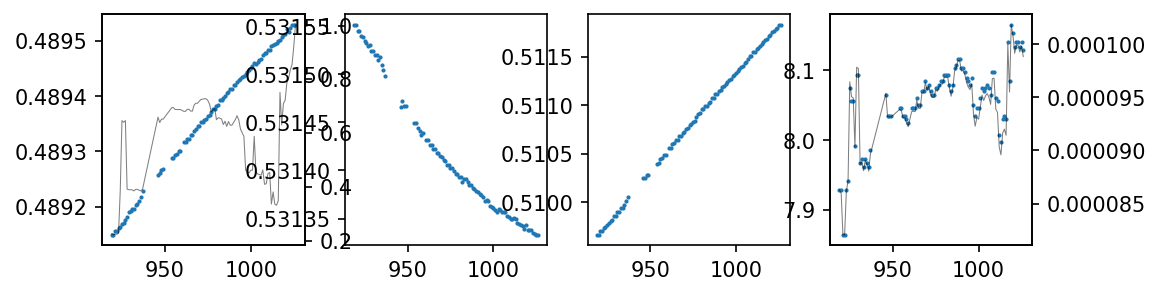

In [123]:
fig, axes = plt.subplots(1,4, dpi=150, figsize=(8,2))
ax = axes[0]
ax.scatter(branch['timestep'], branch['x'], s=1)
ax1 = ax.twinx()
ax1.plot(branch['timestep'], branch['take_score']*branch['give_score'], lw=0.5, c='k', zorder=-1, alpha=0.5)
ax = axes[1]
ax.scatter(branch['timestep'], branch['y'], s=1)
ax = axes[2]
ax.scatter(branch['timestep'], branch['z'], s=1)
ax = axes[3]
ax.scatter(branch['timestep'], np.log10(branch['mvir']), s=1)
ax1 = ax.twinx()
ax1.plot(branch['timestep'], branch['rvir'], lw=0.5, c='k', zorder=-1, alpha=0.5)
plt.show(); plt.close()

# Mass

0.05754958952621089


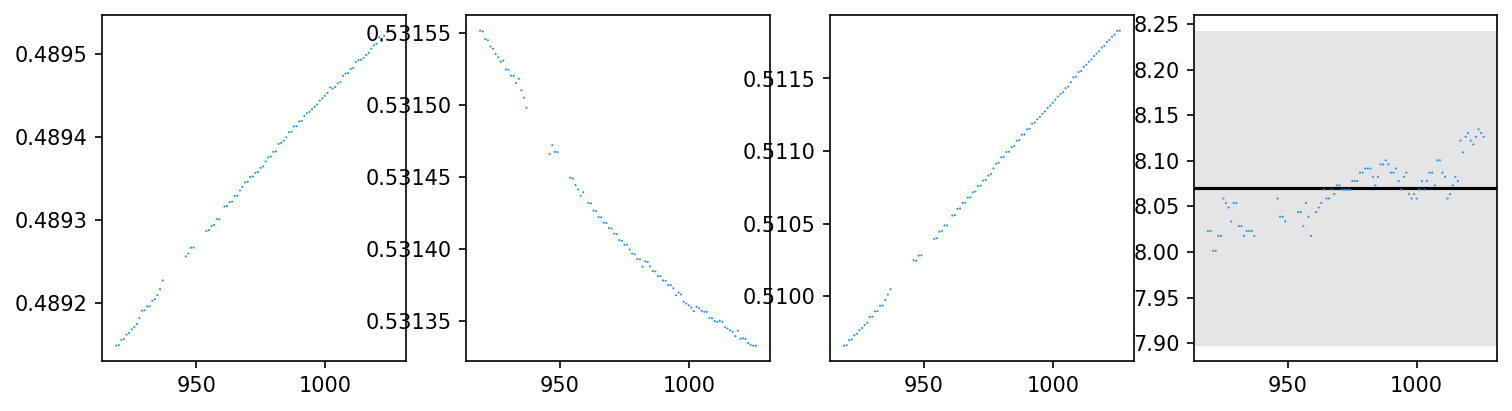

In [124]:
def massbranch(branch):
    val = np.log10(branch['mvir'])
    mask1 = val <= (np.median(val) + 3*np.std(val))
    return mask1

mmask = massbranch(branch)
fig, axes = plt.subplots(1,4, dpi=150, sharex=True, figsize=(12,3))
ax = axes[0]
ax.scatter(branch[~mmask]['timestep'], branch[~mmask]['x'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[mmask]['timestep'], branch[mmask]['x'], s=1, ec='none', fc='dodgerblue')

ax = axes[1]
ax.scatter(branch[~mmask]['timestep'], branch[~mmask]['y'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[mmask]['timestep'], branch[mmask]['y'], s=1, ec='none', fc='dodgerblue')

ax = axes[2]
ax.scatter(branch[~mmask]['timestep'], branch[~mmask]['z'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[mmask]['timestep'], branch[mmask]['z'], s=1, ec='none', fc='dodgerblue')

ax = axes[3]
ax.scatter(branch[~mmask]['timestep'], np.log10(branch[~mmask]['mdm_vir']), s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[mmask]['timestep'], np.log10(branch[mmask]['mdm_vir']), s=1, ec='none', fc='dodgerblue')
median = np.log10(np.median(branch['mvir']))
ax.axhline(median, color='k', zorder=-1)
error = 3*np.std(np.log10(branch['mvir']))
ax.axhspan(median-error, median+error, ec='none', fc='k', alpha=0.1, zorder=-2)
print(error/3)
plt.show(); plt.close()

# Velocity

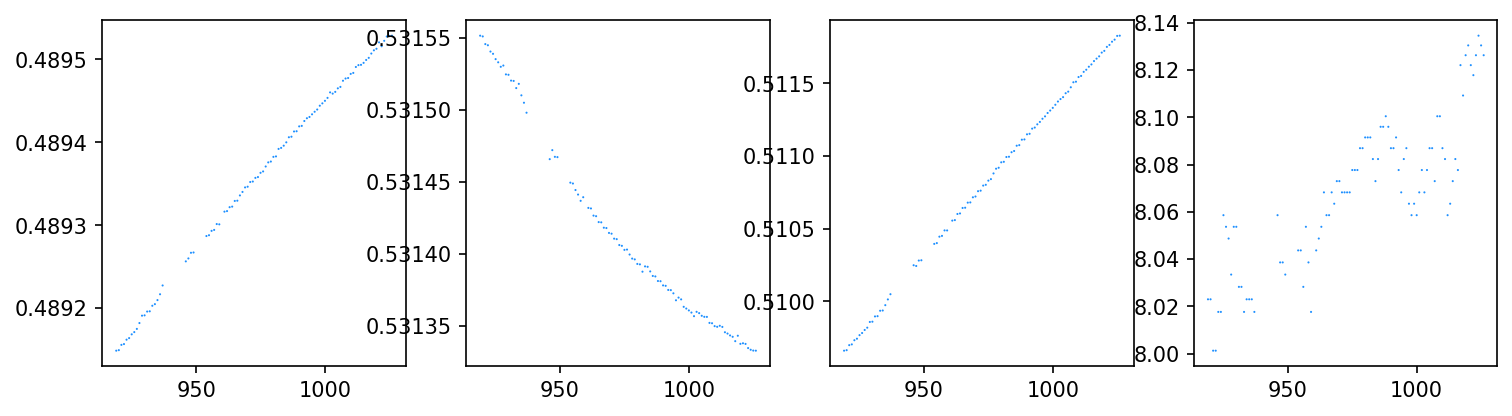

In [125]:
def velbranch(branch, snaps):
    iout = snaps.iout_avail['iout']
    fsnap = snaps.get_snap(iout[-1]); unitl_com = fsnap.unit_l/fsnap.aexp
    aexp = snaps.iout_avail['aexp']
    age = snaps.iout_avail['age']
    mask = np.full(len(branch), False, dtype=bool)
    mask[0] = True
    factor = 1
    for i in range(len(mask)-1):
        if(mask[i]):
            nb = branch[i]
            niout = nb['timestep']; nwhere = np.where(iout == niout)[0][0]; nage = age[nwhere]
            unit_l = unitl_com * aexp[nwhere]
        pb = branch[i+1]
        piout = pb['timestep']; pwhere = np.where(iout == piout)[0][0]; page = age[pwhere]
        dt = (nage - page)*1e9 * 365*24*3600 # sec
        dx = (nb['vx']*dt) * 1e5 # cm
        dy = (nb['vy']*dt) * 1e5
        dz = (nb['vz']*dt) * 1e5
        nnx = nb['x'] - dx/unit_l
        nny = nb['y'] - dy/unit_l
        nnz = nb['z'] - dz/unit_l
        dist2 = np.sqrt( (nnx-pb['x'])**2 + (nny-pb['y'])**2 + (nnz-pb['z'])**2 )
        if(dist2 < factor*(nb['rvir']+pb['rvir'])) and (pb['mvir'] < nb['mvir']*1e2):
            mask[i+1] = True
            factor = 1
        else:
            factor += 0.01
    return mask

vmask = velbranch(branch, snap1s)
fig, axes = plt.subplots(1,4, dpi=150, sharex=True, figsize=(12,3))
ax = axes[0]
ax.scatter(branch[~vmask]['timestep'], branch[~vmask]['x'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[vmask]['timestep'], branch[vmask]['x'], s=1, ec='none', fc='dodgerblue')

ax = axes[1]
ax.scatter(branch[~vmask]['timestep'], branch[~vmask]['y'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[vmask]['timestep'], branch[vmask]['y'], s=1, ec='none', fc='dodgerblue')

ax = axes[2]
ax.scatter(branch[~vmask]['timestep'], branch[~vmask]['z'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[vmask]['timestep'], branch[vmask]['z'], s=1, ec='none', fc='dodgerblue')

ax = axes[3]
ax.scatter(branch[~vmask]['timestep'], np.log10(branch[~vmask]['mdm_vir']), s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[vmask]['timestep'], np.log10(branch[vmask]['mdm_vir']), s=1, ec='none', fc='dodgerblue')
plt.show(); plt.close()

# Polynomial

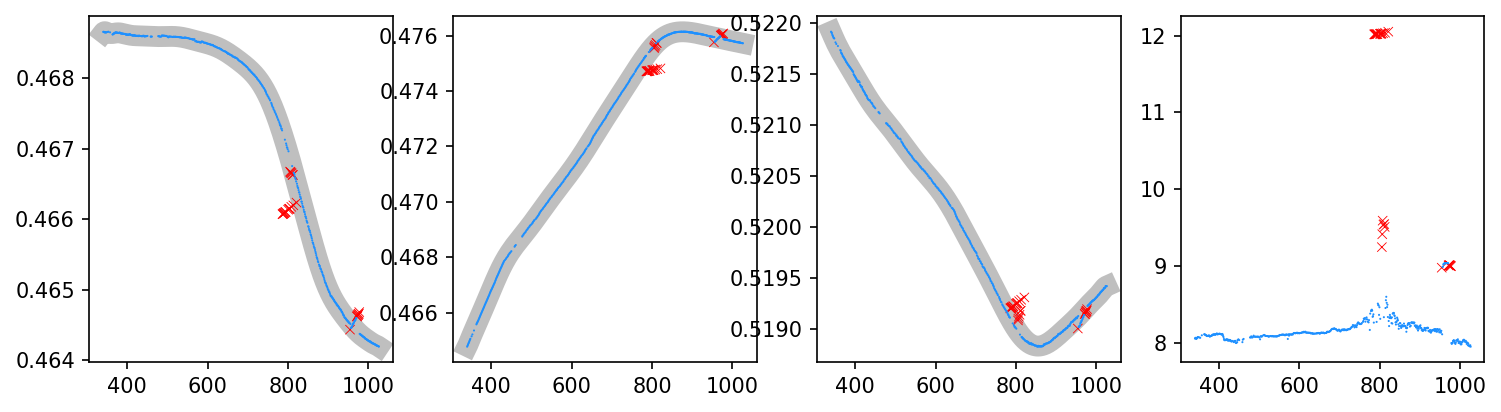

In [117]:
def polybranch(branch, vmask=None, return_poly=False):
    if(vmask is None): vmask = np.full(len(branch), 0)
    score = (branch['take_score']*branch['give_score']) * (vmask+0.5)
    polyx = np.polynomial.polynomial.Polynomial.fit(branch['timestep'], branch['x'], 20, w=score)
    resix = branch['x'] - polyx(branch['timestep'])
    stdx = np.std(resix)
    polyy = np.polynomial.polynomial.Polynomial.fit(branch['timestep'], branch['y'], 20, w=score)
    resiy = branch['y'] - polyy(branch['timestep'])
    stdy = np.std(resiy)
    polyz = np.polynomial.polynomial.Polynomial.fit(branch['timestep'], branch['z'], 20, w=score)
    resiz = branch['z'] - polyz(branch['timestep'])
    stdz = np.std(resiz)

    resi = np.sqrt(resix**2 + resiy**2 + resiz**2)
    where1 = (resi > np.sqrt(stdx**2 + stdy**2 + stdz**2))
    where2 = resi/np.sqrt(3) > 1e-4
    where = where1&where2
    if(return_poly):
        return (~where), polyx, polyy, polyz
    return (~where)

pmask, px, py, pz = polybranch(branch, vmask, return_poly=True)
fig, axes = plt.subplots(1,4, dpi=150, sharex=True, figsize=(12,3))
ax = axes[0]
ax.plot(branch['timestep'], px(branch['timestep']), zorder=-1, color='grey', lw=10, alpha=0.5)
ax.scatter(branch[~pmask]['timestep'], branch[~pmask]['x'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[pmask]['timestep'], branch[pmask]['x'], s=1, ec='none', fc='dodgerblue')

ax = axes[1]
ax.plot(branch['timestep'], py(branch['timestep']), zorder=-1, color='grey', lw=10, alpha=0.5)
ax.scatter(branch[~pmask]['timestep'], branch[~pmask]['y'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[pmask]['timestep'], branch[pmask]['y'], s=1, ec='none', fc='dodgerblue')

ax = axes[2]
ax.plot(branch['timestep'], pz(branch['timestep']), zorder=-1, color='grey', lw=10, alpha=0.5)
ax.scatter(branch[~pmask]['timestep'], branch[~pmask]['z'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[pmask]['timestep'], branch[pmask]['z'], s=1, ec='none', fc='dodgerblue')

ax = axes[3]
ax.scatter(branch[~pmask]['timestep'], np.log10(branch[~pmask]['mdm_vir']), s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[pmask]['timestep'], np.log10(branch[pmask]['mdm_vir']), s=1, ec='none', fc='dodgerblue')
plt.show(); plt.close()

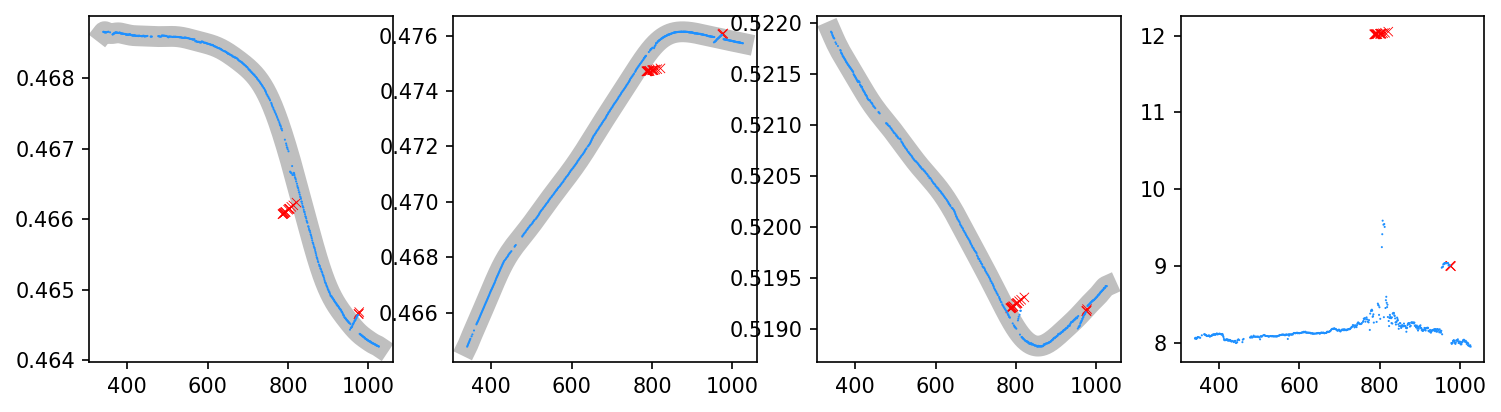

In [118]:
mask = mmask & (vmask|pmask)

fig, axes = plt.subplots(1,4, dpi=150, sharex=True, figsize=(12,3))
ax = axes[0]
ax.plot(branch['timestep'], px(branch['timestep']), zorder=-1, color='grey', lw=10, alpha=0.5)
ax.scatter(branch[~mask]['timestep'], branch[~mask]['x'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[mask]['timestep'], branch[mask]['x'], s=1, ec='none', fc='dodgerblue')

ax = axes[1]
ax.plot(branch['timestep'], py(branch['timestep']), zorder=-1, color='grey', lw=10, alpha=0.5)
ax.scatter(branch[~mask]['timestep'], branch[~mask]['y'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[mask]['timestep'], branch[mask]['y'], s=1, ec='none', fc='dodgerblue')

ax = axes[2]
ax.plot(branch['timestep'], pz(branch['timestep']), zorder=-1, color='grey', lw=10, alpha=0.5)
ax.scatter(branch[~mask]['timestep'], branch[~mask]['z'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[mask]['timestep'], branch[mask]['z'], s=1, ec='none', fc='dodgerblue')

ax = axes[3]
ax.scatter(branch[~mask]['timestep'], np.log10(branch[~mask]['mdm_vir']), s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[mask]['timestep'], np.log10(branch[mask]['mdm_vir']), s=1, ec='none', fc='dodgerblue')
plt.show(); plt.close()

NewHorizon:   0%|          | 0/1336 [00:00<?, ?it/s]

68 5754 9.093414299647211


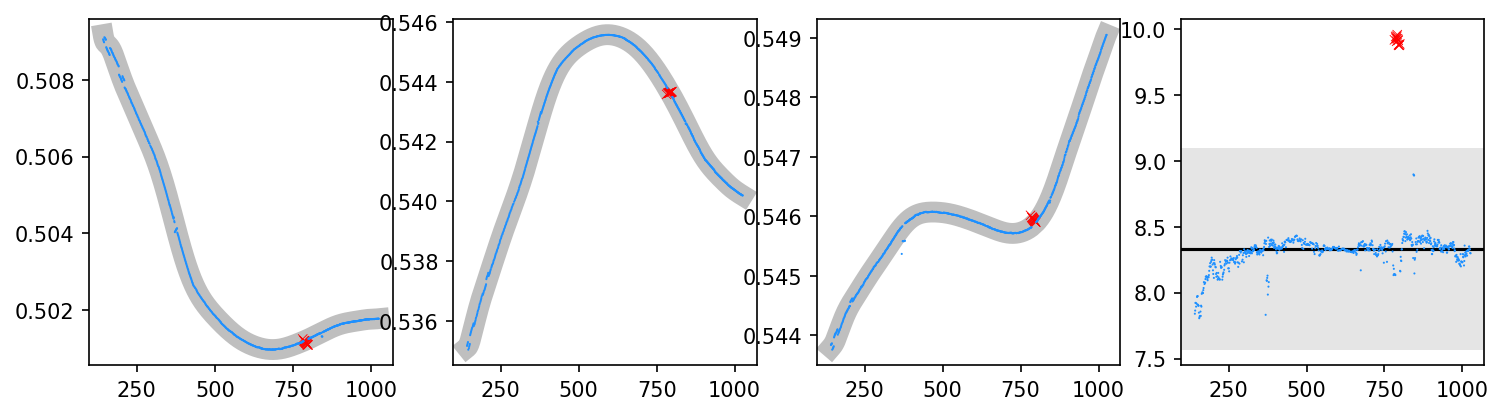

In [211]:
def massbranch(branch):
    val = np.log10(branch['mvir'])
    mask1 = np.full(len(branch), True, dtype=bool)
    for i in range(len(mask1)):
        if(val[i] < 9): continue
        arr = val[max(0,i-100):i+100]
        mask1[i] = val[i] <= (np.mean(arr) + 4*np.std(arr))
    upper = (np.median(val) + 3*np.std(val))
    if(upper>8.5):
        mask2 = val <= upper
        return mask1&mask2
    return mask1

keys = list(rtree1.keys())
count = 0
for key in tqdm(keys, desc='NewHorizon'):
    if(count <= 66):
        count+=1
        continue
    branch = rtree1[key]
    mmask = massbranch(branch)
    mbranch = branch[mmask]
    vmask = velbranch(mbranch, snap1s)
    pmask,px,py,pz = polybranch(mbranch, vmask, return_poly=True)
    # mask = mmask & (vmask|pmask)
    mask = (vmask|pmask)
    val = np.log10(branch['mvir'])
    error = np.std(val)
    maxm = np.max(np.log10(branch['mvir']))
    if(False in mmask):
        if maxm < 10.0:
            print(count, key, np.median(val) + 3*np.std(val))
            break
    count += 1

ind = mmask
fig, axes = plt.subplots(1,4, dpi=150, sharex=True, figsize=(12,3))
ax = axes[0]
ax.plot(mbranch['timestep'], px(mbranch['timestep']), zorder=-1, color='grey', lw=10, alpha=0.5)
ax.scatter(branch[~ind]['timestep'], branch[~ind]['x'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[ind]['timestep'], branch[ind]['x'], s=1, ec='none', fc='dodgerblue')

ax = axes[1]
ax.plot(mbranch['timestep'], py(mbranch['timestep']), zorder=-1, color='grey', lw=10, alpha=0.5)
ax.scatter(branch[~ind]['timestep'], branch[~ind]['y'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[ind]['timestep'], branch[ind]['y'], s=1, ec='none', fc='dodgerblue')

ax = axes[2]
ax.plot(mbranch['timestep'], pz(mbranch['timestep']), zorder=-1, color='grey', lw=10, alpha=0.5)
ax.scatter(branch[~ind]['timestep'], branch[~ind]['z'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[ind]['timestep'], branch[ind]['z'], s=1, ec='none', fc='dodgerblue')

ax = axes[3]
ax.scatter(branch[~ind]['timestep'], np.log10(branch[~ind]['mvir']), s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[ind]['timestep'], np.log10(branch[ind]['mvir']), s=1, ec='none', fc='dodgerblue')
median = np.log10(np.median(branch['mvir']))
ax.axhline(median, color='k', zorder=-1)
error = 3*np.std(np.log10(branch['mvir']))
ax.axhspan(median-error, median+error, ec='none', fc='k', alpha=0.1, zorder=-2)
plt.show(); plt.close()

In [195]:
np.sum(mask)

658

In [186]:
print(dir(px))

['__abstractmethods__', '__add__', '__array_ufunc__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__divmod__', '__doc__', '__eq__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__pos__', '__pow__', '__radd__', '__rdiv__', '__rdivmod__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rmod__', '__rmul__', '__rsub__', '__rtruediv__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '_abc_impl', '_add', '_der', '_div', '_fit', '_fromroots', '_generate_string', '_get_coefficients', '_int', '_line', '_mul', '_pow', '_repr_latex_', '_repr_latex_scalar', '_repr_latex_term', '_roots', '_str_term_ascii', '_str_term_unicode', '_sub', '_subscript_mapping', '_superscript_mapping', '_use_un

In [180]:
px.coef

array([ 4.70733447e-01, -1.37695254e-02,  8.83924597e-03,  3.09706652e-02,
       -1.98776097e-01,  1.11011093e-01,  2.14034959e+00, -2.76587604e+00,
       -1.19178637e+01,  1.90490495e+01,  3.83299893e+01, -7.13593171e+01,
       -7.13380228e+01,  1.61144611e+02,  6.65598736e+01, -2.19180110e+02,
       -6.27606142e+00,  1.65456819e+02, -3.97008954e+01, -5.32252404e+01,
        2.31402817e+01])

In [194]:
px[0]

TypeError: 'Polynomial' object is not subscriptable

In [119]:
stop()

ValueError: stop!

In [ ]:
fig, axes = plt.subplots(1,4, dpi=150, sharex=True, figsize=(12,3))
ax = axes[0]
ax.scatter(branch[~vmask]['timestep'], branch[~vmask]['x'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[vmask]['timestep'], branch[vmask]['x'], s=1, ec='none', fc='dodgerblue')

ax = axes[1]
ax.scatter(branch[~vmask]['timestep'], branch[~vmask]['y'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[vmask]['timestep'], branch[vmask]['y'], s=1, ec='none', fc='dodgerblue')

ax = axes[2]
ax.scatter(branch[~vmask]['timestep'], branch[~vmask]['z'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[vmask]['timestep'], branch[vmask]['z'], s=1, ec='none', fc='dodgerblue')

ax = axes[3]
ax.scatter(branch[~vmask]['timestep'], np.log10(branch[~vmask]['mdm_vir']), s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[vmask]['timestep'], np.log10(branch[vmask]['mdm_vir']), s=1, ec='none', fc='dodgerblue')

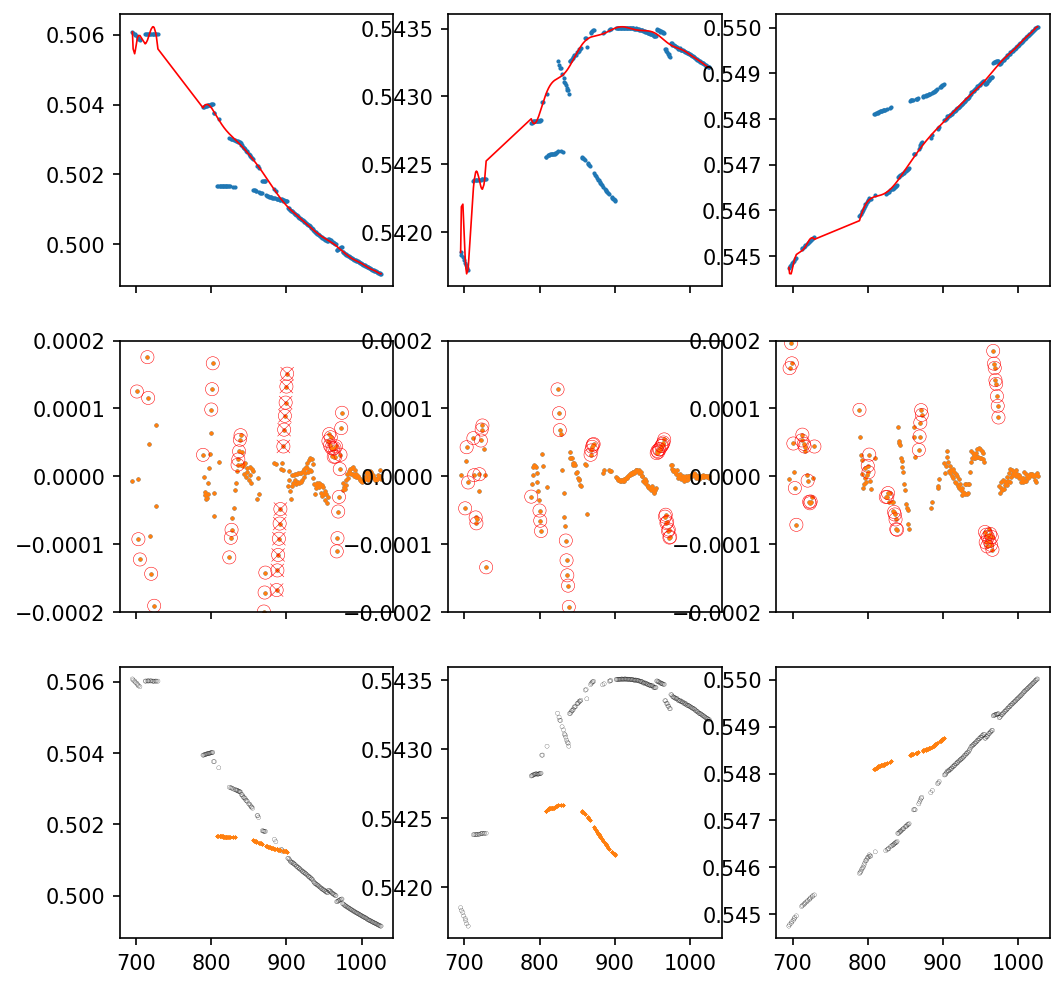

In [ ]:
score = (branch['take_score']*branch['give_score']) * (vmask+1)

fig, axes = plt.subplots(3,3, dpi=150, sharex=True, figsize=(8,8))
ax = axes[0,0]
ax.scatter(branch['timestep'], branch['x'], s=1)
poly = np.polynomial.polynomial.Polynomial.fit(branch['timestep'], branch['x'], 20, w=score)
ax.plot(branch['timestep'], poly(branch['timestep']), 'r-', lw=0.8)
ax = axes[1,0]
resix = branch['x'] - poly(branch['timestep'])
stdx = np.std(resix)
wherex = np.abs(resix) < 3*stdx
ax.scatter(branch['timestep'], resix, s=1)
ax.scatter(branch[wherex]['timestep'], resix[wherex], s=1)

ax = axes[0,1]
ax.scatter(branch['timestep'], branch['y'], s=1)
poly = np.polynomial.polynomial.Polynomial.fit(branch['timestep'], branch['y'], 20, w=score)
ax.plot(branch['timestep'], poly(branch['timestep']), 'r-', lw=0.8)
ax = axes[1,1]
resiy = branch['y'] - poly(branch['timestep'])
stdy = np.std(resiy)
wherey = np.abs(resiy) < 3*stdy
ax.scatter(branch['timestep'], resiy, s=1)
ax.scatter(branch[wherey]['timestep'], resiy[wherey], s=1)

ax = axes[0,2]
ax.scatter(branch['timestep'], branch['z'], s=1)
poly = np.polynomial.polynomial.Polynomial.fit(branch['timestep'], branch['z'], 20, w=score)
ax.plot(branch['timestep'], poly(branch['timestep']), 'r-', lw=0.8)
ax = axes[1,2]
resiz = branch['z'] - poly(branch['timestep'])
stdz = np.std(resiz)
wherez = np.abs(resiz) < 3*stdz
ax.scatter(branch['timestep'], resiz, s=1)
ax.scatter(branch[wherez]['timestep'], resiz[wherez], s=1)

# where = ~wherex & ~wherey & ~wherez
resi = np.sqrt(resix**2 + resiy**2 + resiz**2)
where1 = resi > np.sqrt(stdx**2 + stdy**2 + stdz**2)
where2 = resi > 1e-4
where = where1&where2
axes[1,0].scatter(branch[where1]['timestep'], resix[where1], s=40, marker='x', ec='r', fc='none', lw=0.25)
axes[1,1].scatter(branch[where1]['timestep'], resiy[where1], s=40, marker='x', ec='r', fc='none', lw=0.25)
axes[1,2].scatter(branch[where1]['timestep'], resiz[where1], s=40, marker='x', ec='r', fc='none', lw=0.25)
axes[1,0].scatter(branch[where2]['timestep'], resix[where2], s=40, marker='o', ec='r', fc='none', lw=0.25)
axes[1,1].scatter(branch[where2]['timestep'], resiy[where2], s=40, marker='o', ec='r', fc='none', lw=0.25)
axes[1,2].scatter(branch[where2]['timestep'], resiz[where2], s=40, marker='o', ec='r', fc='none', lw=0.25)
axes[1,0].set_ylim(-2e-4, 2e-4)
axes[1,1].set_ylim(-2e-4, 2e-4)
axes[1,2].set_ylim(-2e-4, 2e-4)

ax = axes[2,0]
ax.scatter(branch[~where]['timestep'], branch[~where]['x'], s=4, ec='k', fc='none', lw=0.1)
ax.scatter(branch[where]['timestep'], branch[where]['x'], s=1, marker='x')
ax = axes[2,1]
ax.scatter(branch[~where]['timestep'], branch[~where]['y'], s=4, ec='k', fc='none', lw=0.1)
ax.scatter(branch[where]['timestep'], branch[where]['y'], s=1, marker='x')
ax = axes[2,2]
ax.scatter(branch[~where]['timestep'], branch[~where]['z'], s=4, ec='k', fc='none', lw=0.1)
ax.scatter(branch[where]['timestep'], branch[where]['z'], s=1, marker='x')

254 204 60 204


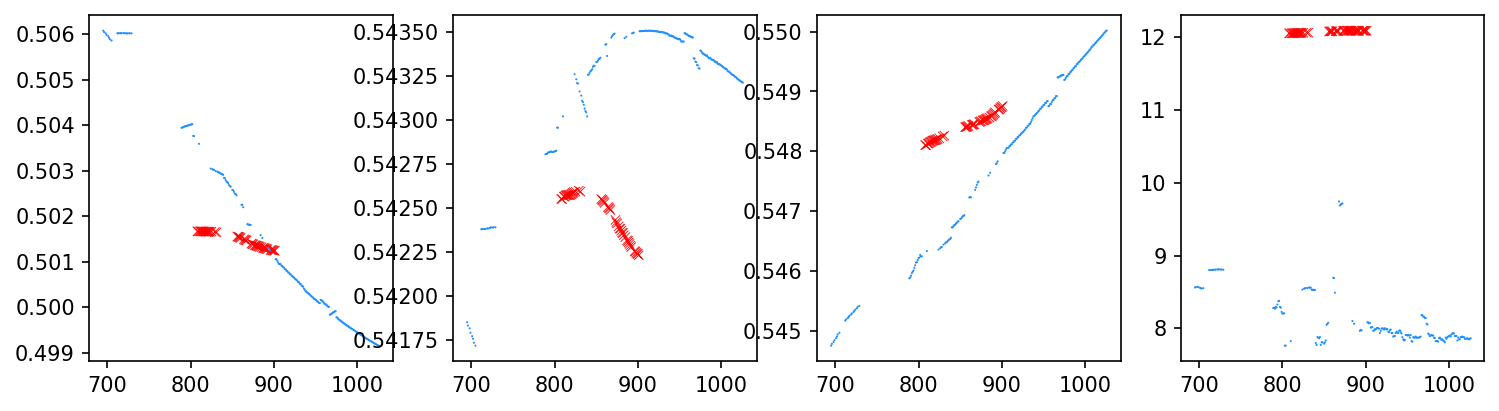

In [ ]:
ind = (~where)|(vmask)
print(len(vmask), np.sum(~where), np.sum(vmask), np.sum(ind))
fig, axes = plt.subplots(1,4, dpi=150, sharex=True, figsize=(12,3))
ax = axes[0]
ax.scatter(branch[~ind]['timestep'], branch[~ind]['x'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[ind]['timestep'], branch[ind]['x'], s=1, ec='none', fc='dodgerblue')

ax = axes[1]
ax.scatter(branch[~ind]['timestep'], branch[~ind]['y'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[ind]['timestep'], branch[ind]['y'], s=1, ec='none', fc='dodgerblue')

ax = axes[2]
ax.scatter(branch[~ind]['timestep'], branch[~ind]['z'], s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[ind]['timestep'], branch[ind]['z'], s=1, ec='none', fc='dodgerblue')

ax = axes[3]
ax.scatter(branch[~ind]['timestep'], np.log10(branch[~ind]['mdm_vir']), s=20, ec='r', fc='none', lw=0.4, marker='x')
ax.scatter(branch[ind]['timestep'], np.log10(branch[ind]['mdm_vir']), s=1, ec='none', fc='dodgerblue')

In [ ]:
def velbranch(branch):
    mask = np.full(len(branch), False, dtype=bool)
    mask[0] = True
    factor = 1
    for i in range(len(mask)-1):
        if(mask[i]):
            nb = branch[i]
            niout = nb['timestep']; nsnap = snaps.get_snap(niout); nage = nsnap.age
        pb = branch[i+1]
        piout = pb['timestep']; psnap = snaps.get_snap(piout); page = psnap.age
        dt = (nage - page)*1e9 * 365*24*3600 # sec
        dx = (nb['vx']*dt) * 1e5 # cm
        dy = (nb['vy']*dt) * 1e5
        dz = (nb['vz']*dt) * 1e5
        nnx = nb['x'] - dx/nsnap.unit_l
        nny = nb['y'] - dy/nsnap.unit_l
        nnz = nb['z'] - dz/nsnap.unit_l
        dist2 = np.sqrt( (nnx-pb['x'])**2 + (nny-pb['y'])**2 + (nnz-pb['z'])**2 )
        if(dist2 < factor*(nb['rvir']+pb['rvir'])) and (pb['mvir'] < nb['mvir']*1e2):
            mask[i+1] = True
            factor = 1
        else:
            factor += 0.01
    return mask

def polybranch(branch, vmask=None):
    if(vmask is None): vmask = np.full(len(branch), 0)
    score = (branch['take_score']*branch['give_score']) * (vmask+0.5)
    poly = np.polynomial.polynomial.Polynomial.fit(branch['timestep'], branch['x'], 20, w=score)
    resix = branch['x'] - poly(branch['timestep'])
    stdx = np.std(resix)
    poly = np.polynomial.polynomial.Polynomial.fit(branch['timestep'], branch['y'], 20, w=score)
    resiy = branch['y'] - poly(branch['timestep'])
    stdy = np.std(resiy)
    poly = np.polynomial.polynomial.Polynomial.fit(branch['timestep'], branch['z'], 20, w=score)
    resiz = branch['z'] - poly(branch['timestep'])
    stdz = np.std(resiz)
    poly = np.polynomial.polynomial.Polynomial.fit(branch['timestep'], np.log10(branch['mvir']), 20, w=score)
    resim = np.log10(branch['mvir']) - poly(branch['timestep'])
    stdm = np.std(resim)
    
    resi = np.sqrt(resix**2 + resiy**2 + resiz**2)
    where1 = (resi > np.sqrt(stdx**2 + stdy**2 + stdz**2))
    where2 = resi/np.sqrt(3) > 1e-4
    # where3 = branch['mvir'] > np.median(branch['mvir'])*1e3
    where = where1&where2|(resim > stdm*3)
    return (~where)|vmask

vmask = velbranch(branch)
mask = polybranch(branch, vmask)
fig, axes = plt.subplots(1,4, dpi=150, figsize=(8,2))
ax = axes[0]
ax.scatter(branch['timestep'], branch['x'], s=20, fc='none', ec='k', lw=0.15)
ax.scatter(branch[vmask]['timestep'], branch[vmask]['x'], s=10, marker='x', color='dodgerblue', lw=0.5)
ax.scatter(branch[mask]['timestep'], branch[mask]['x'], s=0.1, fc='r')
ax = axes[1]
ax.scatter(branch['timestep'], branch['y'], s=20, fc='none', ec='k', lw=0.15)
ax.scatter(branch[vmask]['timestep'], branch[vmask]['y'], s=10, marker='x', color='dodgerblue', lw=0.5)
ax.scatter(branch[mask]['timestep'], branch[mask]['y'], s=0.1, fc='r')
ax = axes[2]
ax.scatter(branch['timestep'], branch['z'], s=20, fc='none', ec='k', lw=0.15)
ax.scatter(branch[vmask]['timestep'], branch[vmask]['z'], s=10, marker='x', color='dodgerblue', lw=0.5)
ax.scatter(branch[mask]['timestep'], branch[mask]['z'], s=0.1, fc='r')
ax = axes[3]
ax.scatter(branch['timestep'], np.log10(branch['mvir']), s=20, fc='none', ec='k', lw=0.15)
ax.scatter(branch[vmask]['timestep'], np.log10(branch[vmask]['mvir']), s=10, marker='x', color='dodgerblue', lw=0.5)
ax.scatter(branch[mask]['timestep'], np.log10(branch[mask]['mvir']), s=0.1, fc='r')